<a href="https://colab.research.google.com/github/gauthamys/CS517-SRAI/blob/main/SRAI_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRAI HW 1

*   Gautham Satyanarayana
*   Pradeep Raj



IMP : Upload 'compas-scores-two-years.csv' before running

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


# Fairness Metrics

## Demographic Parity

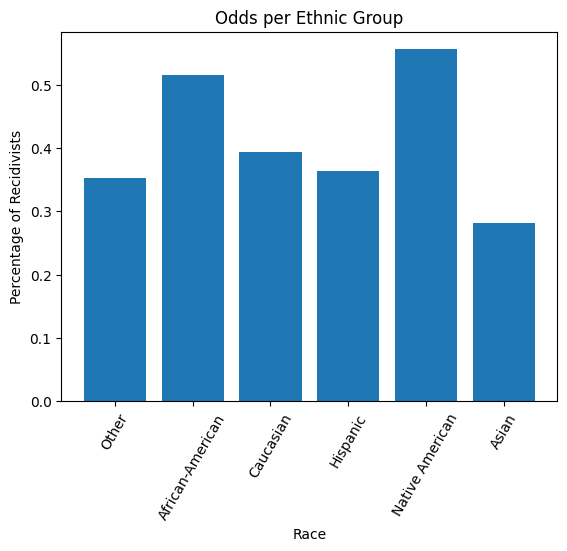

In [15]:
races = []
ps = []
for race in df['race'].unique():
    race_df = df[df['race'] == race]
    percentage = (race_df['two_year_recid'] == 1).sum() / len(race_df)
    races.append(race)
    ps.append(percentage)
    #print(f"{race} : {percentage:.2f}")
#plot
import matplotlib.pyplot as plt
plt.bar(races, ps)
plt.xlabel('Race')
plt.xticks(rotation=60)
plt.ylabel('Percentage of Recidivists')
plt.title('Odds per Ethnic Group')
plt.show()

## Equalised Odds

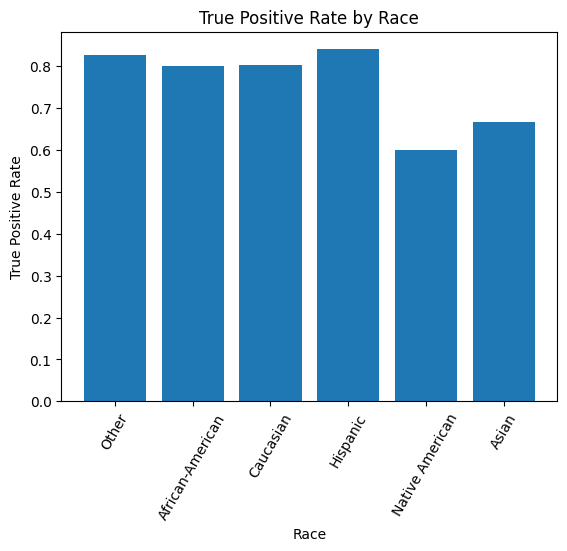

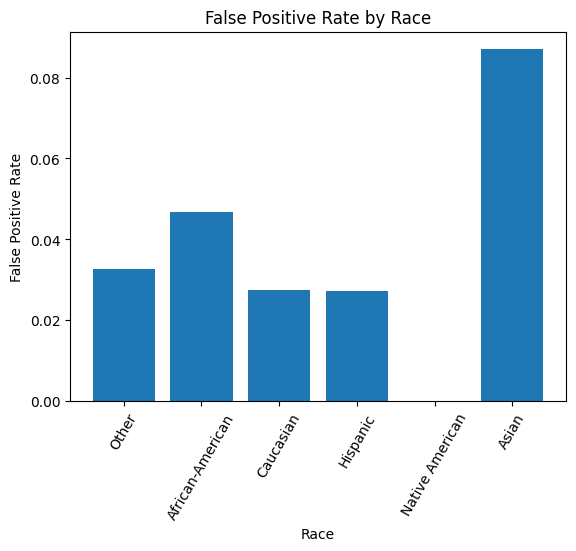

In [16]:
from sklearn.metrics import confusion_matrix
tps = []
fps = []
races = []
for race in df['race'].unique():
    race_df = df[df['race'] == race]

    tn, fp, fn, tp = confusion_matrix(race_df['two_year_recid'], race_df['event']).ravel()

    true_positive_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

    tps.append(true_positive_rate)
    fps.append(false_positive_rate)
    races.append(race)

    # print(f"Race: {race}")
    # print(f"  True Positive Rate: {true_positive_rate:.2f}")
    # print(f"  False Positive Rate: {false_positive_rate:.2f}")
    # print("-" * 20)

#plot multi bar graph
import matplotlib.pyplot as plt
plt.bar(races, tps, label='True Positive Rate')
plt.xlabel('Race')
plt.ylabel('True Positive Rate')
plt.title('True Positive Rate by Race')
plt.xticks(rotation=60)
plt.show()

plt.bar(races, fps, label='False Positive Rate')
plt.xlabel('Race')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate by Race')
plt.xticks(rotation=60)
plt.show()

## Equalised Opportunity / Predictive Rate Parity

- The True Positive rates for all races are comparable, except "Native American" and "Asian"
- Caucasian and African-American have equal odds
- Asian and Native American are comparable, although Asian has higher odds
- Hispanic and Other have similar odds

# Bias Mitigation Strategies

## Conterfactual Data Augmentation

## Fairness Constraints

In [18]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

In [45]:
def calculate_age(d):
    """
    Calculate age from date of birth.
    """
    today = datetime.today()
    return today.year - d.year - ((today.month, today.day) < (d.month, d.day))

def custom_loss(y_true, y_pred):
    """
    Custom loss function: Mean Squared Error with penalty for large deviations.
    """
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    penalty = tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) > 5, tf.float32)) * 10  # Additional penalty for errors > 5
    return mse + penalty

def fairness_loss(y_true, y_pred):
    """
    Custom Keras loss that adds a penalty if
    |P(ŷ=1 | z=0, y=-1) - P(ŷ=1 | z=1, y=-1)| > ε.

    Expects y_true to have shape (batch_size, 2):
        y_true[:, 0] = actual label (assumed here to be in {1, -1})
        y_true[:, 1] = protected attribute z (in {0,1})
    y_pred is the raw (logit) output of the network.
    """
    # Hyperparameters
    epsilon = 0.05   # the allowable difference
    lambda_ = 1.0    # how strongly we penalize fairness violations

    # Separate out the true labels and protected attribute
    y = y_true[:, 0]
    z = y_true[:, 1]

    # Convert labels {1, -1} -> {1, 0} for standard binary crossentropy
    y_pos = (y + 1) / 2.0  # Now y_pos in {0,1}

    # Compute usual binary cross-entropy classification loss
    # y_pred are logits, so we can use sigmoid_cross_entropy_with_logits
    logits_squeezed = tf.squeeze(y_pred, axis=-1)  # Now shape (batch_size,)
    classification_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels=y_pos, logits=logits_squeezed)
    )

    # Get predicted probabilities P(ŷ=1)
    p = tf.sigmoid(y_pred)

    # Mask for the subgroup z=0, y=-1
    mask0 = tf.logical_and(tf.equal(z, 0.0), tf.equal(y, -1.0))
    # Mask for the subgroup z=1, y=-1
    mask1 = tf.logical_and(tf.equal(z, 1.0), tf.equal(y, -1.0))

    # Extract the predicted probabilities in each subgroup
    p0 = tf.boolean_mask(p, mask0)
    p1 = tf.boolean_mask(p, mask1)

    # Use tf.cond to safely compute means if the masks are not empty
    mean_p0 = tf.cond(
        tf.greater(tf.size(p0), 0),
        lambda: tf.reduce_mean(p0),
        lambda: tf.constant(0.0)
    )
    mean_p1 = tf.cond(
        tf.greater(tf.size(p1), 0),
        lambda: tf.reduce_mean(p1),
        lambda: tf.constant(0.0)
    )

    # Difference in average predicted probabilities
    diff = mean_p0 - mean_p1

    # Fairness penalty = hinge around [-ε, ε]
    #   penalty = max(0, diff - ε) + max(0, -ε - diff)
    penalty = tf.maximum(0.0, diff - epsilon) + tf.maximum(0.0, -epsilon - diff)

    # Final loss = classification_loss + λ * fairness_penalty
    return classification_loss + lambda_ * penalty


In [46]:
data = df.rename(columns={
    'priors_count': 'history_violence',
    'juv_other_count': 'vocational_edu',  # Placeholder, adjust as needed
    'juv_misd_count': 'history_nc',
    'two_year_recid': 'risk_score'
})
race_mapping = {r: i + 1 for i, r in enumerate(df['race'].unique())}
data['race'] = df['race'].map(race_mapping)
data['c_offense_date'] = pd.to_datetime(data['c_offense_date'])
data['age_first'] = data['c_offense_date'].apply(calculate_age)
features = ['age', 'age_first', 'history_violence', 'vocational_edu', 'history_nc', 'race']
data = data.dropna(subset= features + ['risk_score'])

X = data[features]
y = data['risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
z_train = X_train['race']
X_train.shape[0], X_test.shape[0]

(4844, 1211)

In [58]:
import numpy as np

# Suppose y_train and z_train are Pandas Series
# Convert each to a NumPy array and reshape to 2D
y_train_2d = y_train.values.reshape(-1, 1)
z_train_2d = z_train.values.reshape(-1, 1)

# Now stack them horizontally to get shape (n_samples, 2)
y_train_combined = np.hstack([y_train_2d, z_train_2d])

### Loss Function = Mean Squared Error

In [59]:
model_keras = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
model_keras.compile(optimizer='adam', loss='mean_squared_error')
model_keras.fit(X_train, y_train_combined, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.5456
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3286
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.3314
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3386
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3273
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3528
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3081
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3298
Epoch 9/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3093
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3529
Epoch 11/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3393
Epoch 12/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3013
Epoch 13/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3501
Epoch 14/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3542
Epoch 15/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [75]:
loss = model_keras.evaluate(X_test, y_test_combined)
print(loss)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3289
1.3416050672531128


### Loss Function = Mean Squared Error with Fairness Penalty

In [71]:
fair_model_keras = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
fair_model_keras.compile(optimizer='adam', loss=fairness_loss)
fair_model_keras.fit(X_train, y_train_combined, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6373
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5779
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5746
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5766
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5620
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5803
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5696
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5722
Epoch 9/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5708
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5705
Epoch 11/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5657
Epoch 12/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5708
Epoch 13/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5678
Epoch 14/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5742
Epoch 15/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [77]:
# accuracy
z_test = X_test['race']
y_test_combined  = np.column_stack([y_test.values, z_test.values])
loss = fair_model_keras.evaluate(X_test, y_test_combined)
print(f"loss: {loss}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5476
loss: 0.5569446086883545


## MISC

In [11]:
df2 = pd.read_csv('compas-scores-raw.csv')
df2.columns

Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted'],
      dtype='object')

In [87]:
df2[['Case_ID','RecSupervisionLevel', 'Ethnic_Code_Text', 'DateOfBirth', 'ScaleSet_ID', 'Screening_Date', 'MaritalStatus', 'RawScore']].head()

,Case_ID,RecSupervisionLevel,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,Screening_Date,MaritalStatus,RawScore
0,51950,1,Caucasian,12/05/92,22,1/1/13 0:00,Single,-2.08
1,51950,1,Caucasian,12/05/92,22,1/1/13 0:00,Single,-1.06
2,51950,1,Caucasian,12/05/92,22,1/1/13 0:00,Single,15.00
3,51956,1,Caucasian,09/16/84,22,1/1/13 0:00,Married,-2.84
4,51956,1,Caucasian,09/16/84,22,1/1/13 0:00,Married,-1.50
